In [3]:
using LinearAlgebra
using ITensors, ITensorMPS
using Plots
using JLD2

In [4]:
include("../src/states.jl")

include("../src/circuits.jl")
include("../src/defs.jl")
include("../src/dynamics.jl")
include("../src/observables.jl")
include("../src/measurements.jl")

forced_measure_with_val (generic function with 2 methods)

In [6]:
L = 3
T = 10
γ = 0.1
λ = 0.0
ψ0 = diagonal_neelstate(L)

ψ, data, terminal_data = circuit(ψ0, L, T, γ, λ; observables=Symbol[], PBC=false, cutoff=1E-8, maxdim=200, r=1);

In [7]:
entropy(to_vector(ψ.mps))

1.0960350988658825 + 0.0im

In [2]:
using ITensors

# Extract Ai as (χl,d,χr) no matter the internal order
@inline function _to_axb(Ai::ITensor, li::Union{Index,Nothing}, si::Index, ri::Union{Index,Nothing})
    if li === nothing && ri === nothing
        d = dim(si); return reshape(array(Ai, si), 1, d, 1)
    elseif li === nothing
        Ar = array(Ai, si, ri); return reshape(Ar, 1, size(Ar,1), size(Ar,2))
    elseif ri === nothing
        Al = array(Ai, li, si); return reshape(Al, size(Al,1), size(Al,2), 1)
    else
        return array(Ai, li, si, ri)
    end
end

# Make a *copy* of P that is sum-canonical: for each site, Σ_x A[a,x,b] row-stochastic.
function _sum_canonical_copy(P::MPS)
    L = length(P); s = siteinds(P)
    link(i) = (1 <= i <= L-1) ? linkind(P, i) : nothing

    # Dense cores
    A = [ _to_axb(P[i], (i==1 ? nothing : link(i-1)), s[i], (i<=L-1 ? link(i) : nothing)) for i in 1:L ]

    # Right “sum” environments for original cores
    S = [begin
        χl,d,χr = size(Ai)
        M = zeros(Float64, χl, χr)
        @inbounds for a in 1:χl, b in 1:χr
            acc = 0.0; for x in 1:d; acc += Ai[a,x,b]; end
            M[a,b] = acc
        end
        M
    end for Ai in A]
    R = Vector{Vector{Float64}}(undef, L+1)
    R[L+1] = ones(Float64, size(A[L],3))
    for i in L:-1:1
        R[i] = S[i] * R[i+1]
    end

    # Diagonal scalings D_0..D_L (as vectors of positive entries)
    D = [ones(Float64, size(A[1],1))]   # D_0
    for i in 1:L
        χl,d,χr = size(A[i])
        # for each left state a with mass, normalize the row so Σ_{x,b} A[a,x,b] * (D_{i}[b]) / D_{i-1}[a] = 1
        # we'll pick D_i iteratively by setting row scales based on the current R[i+1].
        # Target row sum after scaling: 1, using weights of right env R[i+1].
        Di = ones(Float64, χr)
        # compute row sums w.r.t. current right env
        row = zeros(Float64, χl)
        @inbounds for a in 1:χl
            acc = 0.0
            for x in 1:d, b in 1:χr
                acc += A[i][a,x,b] * R[i+1][b]
            end
            row[a] = acc
        end
        # scale rows via left diagonal: Ã[a,x,b] = A[a,x,b] / row[a]
        @inbounds for a in 1:χl
            scale = row[a]
            if scale > 0
                for x in 1:d, b in 1:χr
                    A[i][a,x,b] /= scale
                end
            end
        end
        # after this, with same R[i+1], each row sums to 1; append a placeholder D_i
        push!(D, Di)

        # update S[i], R[i] consistently for next iteration
        @inbounds begin
            for a in 1:χl, b in 1:χr
                acc = 0.0; for x in 1:d; acc += A[i][a,x,b]; end
                S[i][a,b] = acc
            end
            R[i] = S[i] * R[i+1]
        end
    end

    # Build a *new* MPS with scaled cores (same index structure as P)
    Q = deepcopy(P)
    for i in 1:L
        li = (i==1 ? nothing : linkind(P, i-1))
        ri = (i<=L-1 ? linkind(P, i) : nothing)
        si = s[i]
        χl,d,χr = size(A[i])
        # pack back into ITensor following (li, si, ri)
        if li === nothing && ri === nothing
            Q[i] = ITensor(si; init = (inds...)->A[i][1,inds[1],1])
        elseif li === nothing
            T = ITensor(si, ri)
            @inbounds for x in 1:d, b in 1:χr; T[si=>x, ri=>b] = A[i][1,x,b]; end
            Q[i] = T
        elseif ri === nothing
            T = ITensor(li, si)
            @inbounds for a in 1:χl, x in 1:d; T[li=>a, si=>x] = A[i][a,x,1]; end
            Q[i] = T
        else
            T = ITensor(li, si, ri)
            @inbounds for a in 1:χl, x in 1:d, b in 1:χr; T[li=>a, si=>x, ri=>b] = A[i][a,x,b]; end
            Q[i] = T
        end
    end
    return Q
end

"""
    shannon_entropy_mps(P::MPS)

Compute Shannon entropy (nats) of a nonnegative distribution MPS.
Stochasticizes a copy into sum-canonical form, then runs a single forward pass.
"""
function shannon_entropy_mps(P::MPS)
    L = length(P)
    Q = _sum_canonical_copy(P)          # gauge-fix (does not modify P)
    s = siteinds(Q)
    link(i) = (1 <= i <= L-1) ? linkind(Q, i) : nothing

    # Dense stochastic cores and letter-summed S (row-stochastic by construction)
    A = [ _to_axb(Q[i], (i==1 ? nothing : link(i-1)), s[i], (i<=L-1 ? link(i) : nothing)) for i in 1:L ]
    S = [ begin
        χl,d,χr = size(Ai); M = zeros(Float64, χl, χr)
        @inbounds for a in 1:χl, b in 1:χr
            acc = 0.0; for x in 1:d; acc += Ai[a,x,b]; end
            M[a,b] = acc
        end
        M
    end for Ai in A ]

    # Forward pass
    μ = ones(Float64, size(A[1],1))            # prior on left bond
    μ ./= sum(μ)
    H = 0.0
    for i in 1:L
        χl,d,χr = size(A[i])

        # emissions q[a,x] = sum_b A[a,x,b]  (row-stochastic ensures Σ_x q[a,x]=1)
        # local entropy h_i = Σ_a μ[a] * h(q[a,:])
        h_i = 0.0
        @inbounds for a in 1:χl
            μa = μ[a]; if μa == 0.0; continue; end
            row_H = 0.0
            for x in 1:d
                qax = 0.0
                for b in 1:χr; qax += A[i][a,x,b]; end
                if qax > 0; row_H -= qax * log(qax); end
            end
            h_i += μa * row_H
        end
        H += h_i

        # belief update μ_next = μ * S[i] (row-stochastic), then normalize
        μ_next = μ' * S[i]
        μ = vec(μ_next)
        sμ = sum(μ); if sμ > 0; μ ./= sμ; end
    end
    return H
end


shannon_entropy_mps

In [10]:
shannon_entropy_mps(ψ.mps)

0.36526809503014757

In [11]:
entropy(to_vector(ψ.mps))

1.0960350988658825 + 0.0im

In [446]:
to_vector(ψ.mps)

8-element Vector{ComplexF64}:
                   0.0 + 0.0im
                   0.0 + 0.0im
                   0.0 + 0.0im
    0.3249259425773358 + 0.0im
                   0.0 + 0.0im
    0.3660854225876529 + 0.0im
   0.30898863483501154 + 0.0im
 6.860925934826492e-17 + 0.0im

In [44]:
ITensors.set_warn_order(24)

22

In [ ]:
L = 100
T = 1
γ = 0.1
λ = 0.0
ψ0 = diagonal_neelstate(L)

ψ, data, terminal_data = circuit(ψ0, L, T, γ, λ; observables=Symbol[:exact_CMI_corr], PBC=false, cutoff=1E-8, maxdim=200, r=r);

In [368]:
data

Dict{Symbol, Vector} with 1 entry:
  :exact_CMI_corr => [0.0, 0.0, 0.0714112, 0.0]

In [369]:
ρ = reduced(ψ, 50, 52)

8-element Vector{ComplexF64}:
  0.006793054502871515 + 0.0im
   0.07562693398821962 + 0.0im
  0.013586109005743027 + 0.0im
   0.06883387948534804 + 0.0im
    0.0627178751021558 + 0.0im
    0.6900221594245826 + 0.0im
    0.0817429383714119 + 0.0im
 0.0006770501196791918 + 0.0im

In [366]:
vector_CMI(ρ, 2)

0.0714112323949565 + 0.0im

In [ ]:
# full_data = Dict{Tuple{Int,Int,Float64,Float64,Int},Dict}()

Dict{Tuple{Int64, Int64, Float64, Float64, Int64}, Dict}()

In [5]:
full_data = jldopen("../data/25_09_23.jld2", "r") do file
    read(file, "full_data")
end

Dict{Tuple{Int64, Int64, Float64, Float64, Int64}, Dict} with 32 entries:
  (41, 410, 0.1, 0.0, 6)  => Dict{Symbol, Vector}(:exact_CMI_corr=>[0.0, 0.0, 7…
  (41, 410, 0.1, 0.0, 2)  => Dict{Symbol, Vector}(:exact_CMI_corr=>[0.0, 0.0, 0…
  (41, 820, 0.1, 0.0, 5)  => Dict{Symbol, Vector}(:exact_CMI_corr=>[0.0, 0.0, 7…
  (61, 610, 0.1, 0.0, 7)  => Dict{Symbol, Vector}(:exact_CMI_corr=>[0.0, 0.0, 6…
  (21, 210, 0.1, 0.0, 3)  => Dict{Symbol, Vector}(:exact_CMI_corr=>[0.0, 0.0, 0…
  (21, 210, 0.1, 0.0, 1)  => Dict{Symbol, Vector}(:exact_CMI_corr=>[0.0, 0.0, 0…
  (41, 410, 0.1, 0.0, 8)  => Dict{Symbol, Vector}(:exact_CMI_corr=>[0.0, 0.0, 6…
  (21, 210, 0.1, 0.0, 6)  => Dict{Symbol, Vector}(:exact_CMI_corr=>[0.0, 0.0, 7…
  (41, 410, 0.1, 0.0, 5)  => Dict{Symbol, Vector}(:exact_CMI_corr=>[0.0, 0.0, 7…
  (21, 210, 0.1, 0.0, 2)  => Dict{Symbol, Vector}(:exact_CMI_corr=>[0.0, 0.0, 0…
  (41, 410, 0.1, 0.0, 4)  => Dict{Symbol, Vector}(:exact_CMI_corr=>[0.0, 0.0, 7…
  (41, 410, 0.1, 0.0, 10) => Dict{S

In [ ]:
using JLD2

# jldsave("../data/25_09_23.jld2"; full_data)

In [57]:
for L in [101]
    for r in 1:5
        T = 10L
        γ = 0.01
        λ = 0.0

        ψ0 = diagonal_neelstate(L)

        ψ, data, terminal_data = circuit(ψ0, L, T, γ, λ; observables=Symbol[:exact_CMI_corr], PBC=false, cutoff=1E-16, maxdim=200, r=r);
        full_data[(L,T,γ,λ,r)] = data
    end
end

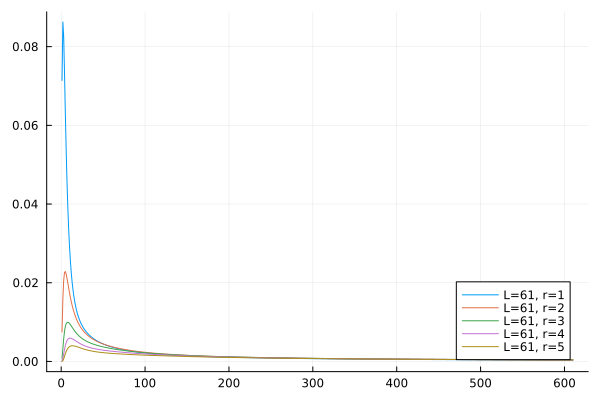

In [23]:
γ = 0.1
λ = 0.0
plt = plot()
for L in [61]
    T = 10L
    for r in 1:5
        xs = collect(0:T)
        ys = full_data[(L,T,γ,λ,r)][:exact_CMI_corr][1:2:end]
        plt = plot!(plt, xs[2:end], ys[2:end], label="L=$L, r=$r",legend=:bottomright)
    end
end

plt

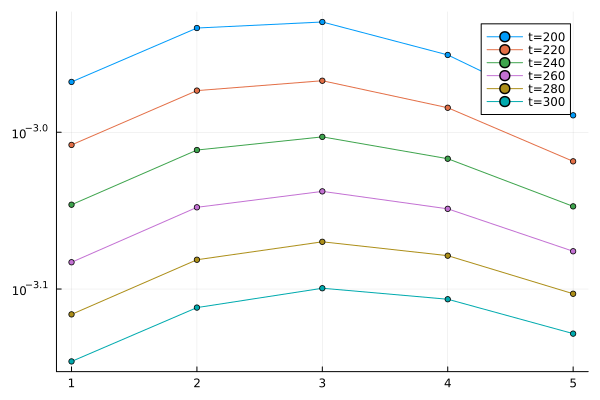

In [22]:
plt = plot()
L = 61
γ = 0.1
T = 10L
for t in 200:20:300
    xs = collect(1:5)
    ys = [full_data[(L,T,γ,λ,r)][:exact_CMI_corr][2t+1] for r in 1:5]
    plot!(plt, xs, ys, label="t=$t", legend=:topright, yscale=:log10, m=3)
end
plt

In [21]:
full_data

Dict{Tuple{Int64, Int64, Float64, Float64, Int64}, Dict} with 32 entries:
  (41, 410, 0.1, 0.0, 6)  => Dict{Symbol, Vector}(:exact_CMI_corr=>[0.0, 0.0, 7…
  (41, 410, 0.1, 0.0, 2)  => Dict{Symbol, Vector}(:exact_CMI_corr=>[0.0, 0.0, 0…
  (41, 820, 0.1, 0.0, 5)  => Dict{Symbol, Vector}(:exact_CMI_corr=>[0.0, 0.0, 7…
  (61, 610, 0.1, 0.0, 7)  => Dict{Symbol, Vector}(:exact_CMI_corr=>[0.0, 0.0, 6…
  (21, 210, 0.1, 0.0, 3)  => Dict{Symbol, Vector}(:exact_CMI_corr=>[0.0, 0.0, 0…
  (21, 210, 0.1, 0.0, 1)  => Dict{Symbol, Vector}(:exact_CMI_corr=>[0.0, 0.0, 0…
  (41, 410, 0.1, 0.0, 8)  => Dict{Symbol, Vector}(:exact_CMI_corr=>[0.0, 0.0, 6…
  (21, 210, 0.1, 0.0, 6)  => Dict{Symbol, Vector}(:exact_CMI_corr=>[0.0, 0.0, 7…
  (41, 410, 0.1, 0.0, 5)  => Dict{Symbol, Vector}(:exact_CMI_corr=>[0.0, 0.0, 7…
  (21, 210, 0.1, 0.0, 2)  => Dict{Symbol, Vector}(:exact_CMI_corr=>[0.0, 0.0, 0…
  (41, 410, 0.1, 0.0, 4)  => Dict{Symbol, Vector}(:exact_CMI_corr=>[0.0, 0.0, 7…
  (41, 410, 0.1, 0.0, 10) => Dict{S

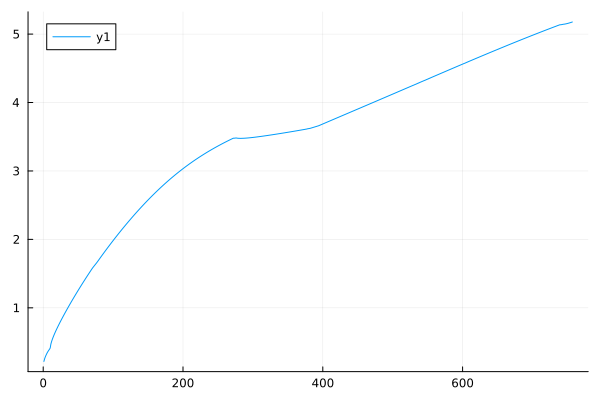

In [50]:
plt = plot()
L = 101
# rs = 6:10

    rs = 2:5
    T = 10L
    xs = collect(0:T)
    ys = -1 ./ [linear_fit_coef(rs, log.([full_data[(L,T,γ,λ,r)][:exact_CMI_corr][t] for r in rs]))[1] for t in 1:2:2T+2]
    plt = plot!(plt, xs[2:3end÷4], ys[2:3end÷4])


plt

In [25]:
using DataFrames, GLM

function linear_fit_coef(x, y)
    # Ensure same length
    @assert length(x) == length(y) "x and y must have same length"
    
    # Fit linear model
    df = DataFrame(X=x, Y=y)
    ols = lm(@formula(Y ~ X), df)
    
    # Get coefficients (intercept and slope)
    b, m = coef(ols)
    
    return m, b
end


linear_fit_coef (generic function with 1 method)

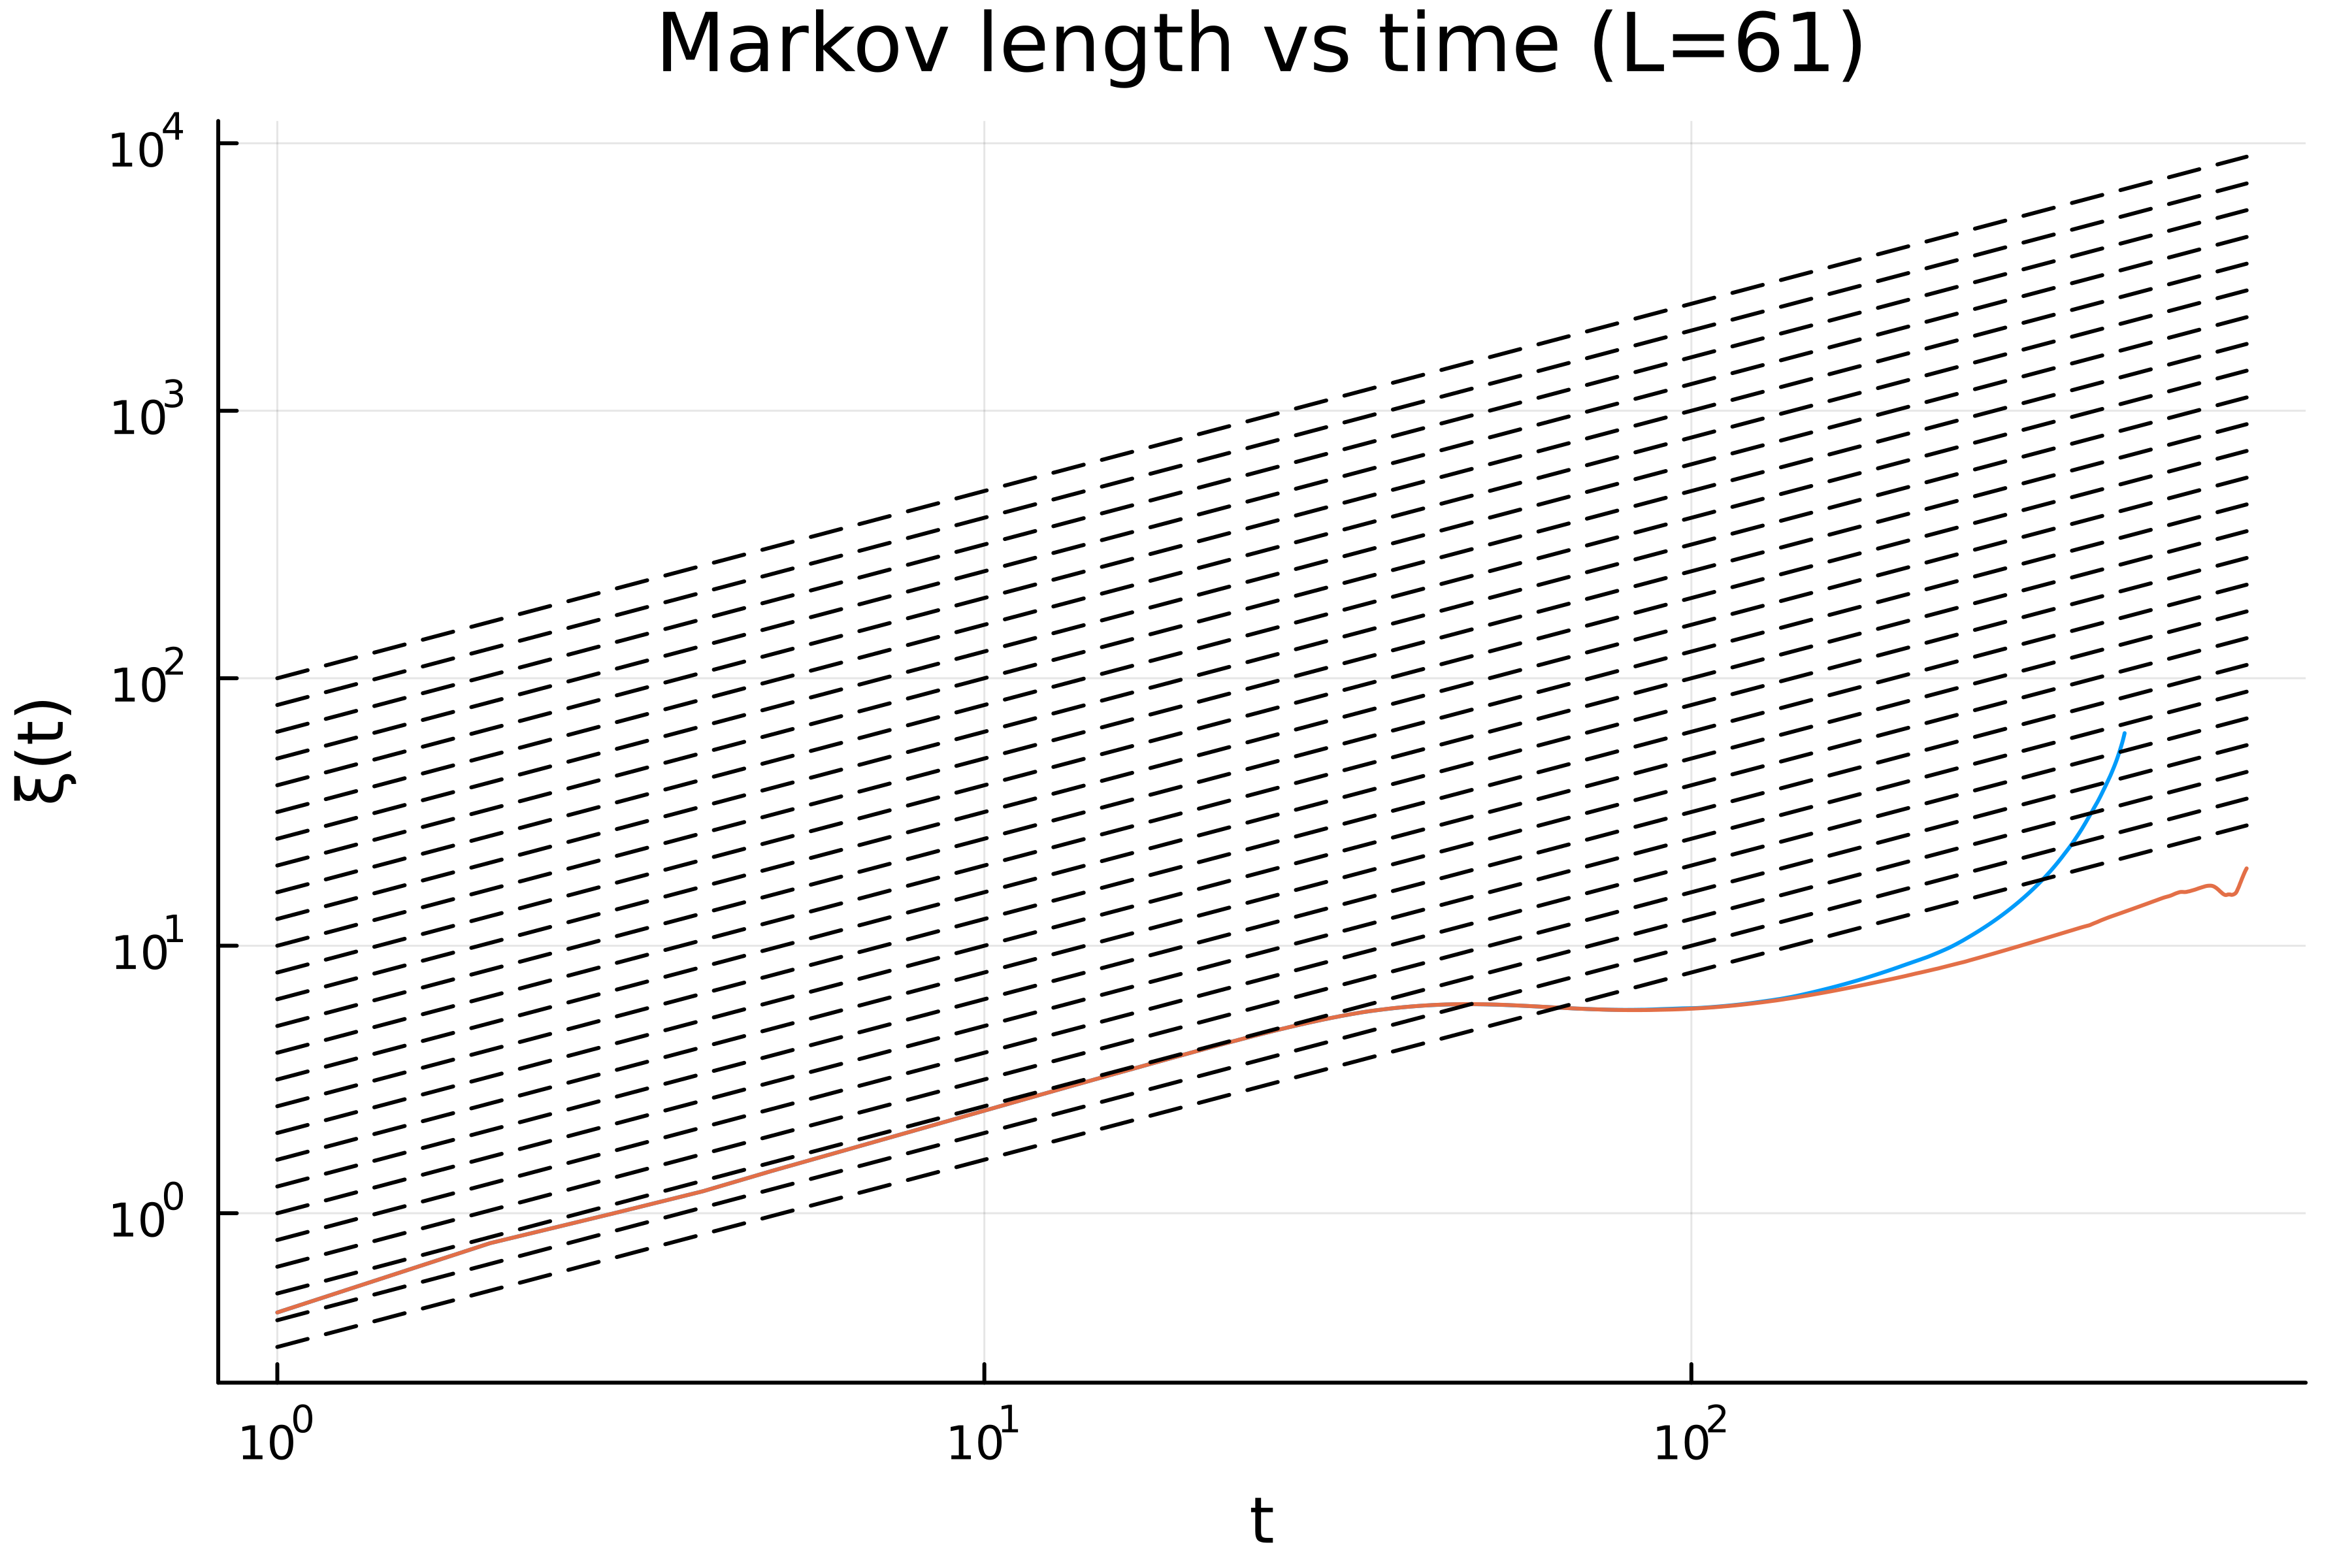

In [40]:
plt = plot()
rs = 5:10
γ = 0.1
for L in [41,61]
    T = 10L
    xs = collect(0:T)
    ys = -1 ./ [linear_fit_coef(rs, log.([full_data[(L,T,γ,λ,r)][:exact_CMI_corr][t] for r in rs]))[1] for t in 1:2:2T+2]
    plt = plot!(plt, xs[2:end], ys[2:end], label="")
end
plot!(plt, xlabel="t", ylabel="ξ(t)", title="Markov length vs time (L=61)", dpi=600, xscale=:log10, yscale=:log10)

for a in -0.5:0.1:2.0
    f(x) = x^0.7 * 10^a
    xs = collect(0:610)
    plot!(plt, xs[2:end], f.(xs[2:end]), label="", lc=:black, ls=:dash)
end

# savefig(plt, "../figs/25_09_24/Markov_length_over_time.png")

plt

In [406]:
plt = plot()
rs = 5:10
for L in [61]
    T = 10L
    xs = collect(0:T)/L
    ys = -1 ./ [linear_fit_coef(rs, log.([full_data[(L,T,γ,λ,r)][:exact_CMI_corr][t] for r in rs]))[1] for t in 1:2:2T+2]
    plt = plot!(plt, sqrt.(xs[2:3end÷4]), ys[2:3end÷4], label="")
end
plot!(plt, xlabel="t/L", ylabel="ξ(t)", title="Markov length vs time (L=61)", dpi=600)

# savefig(plt, "../figs/25_09_24/Markov_length_over_root_time.png")

plt

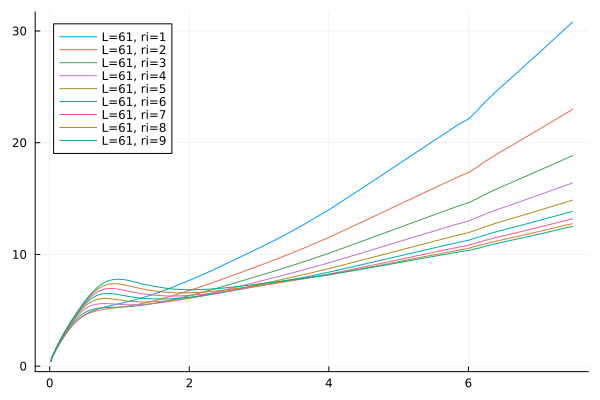

In [304]:
plt = plot()
L = 61
# rs = 6:10
for ri in 1:9
    rs = ri:10
    T = 10L
    xs = collect(0:T)/L
    ys = -1 ./ [linear_fit_coef(rs, log.([full_data[(L,T,γ,λ,r)][:exact_CMI_corr][t] for r in rs]))[1] for t in 1:2:2T+2]
    plt = plot!(plt, xs[2:3end÷4], ys[2:3end÷4], label="L=$L, ri=$ri")
end

plt

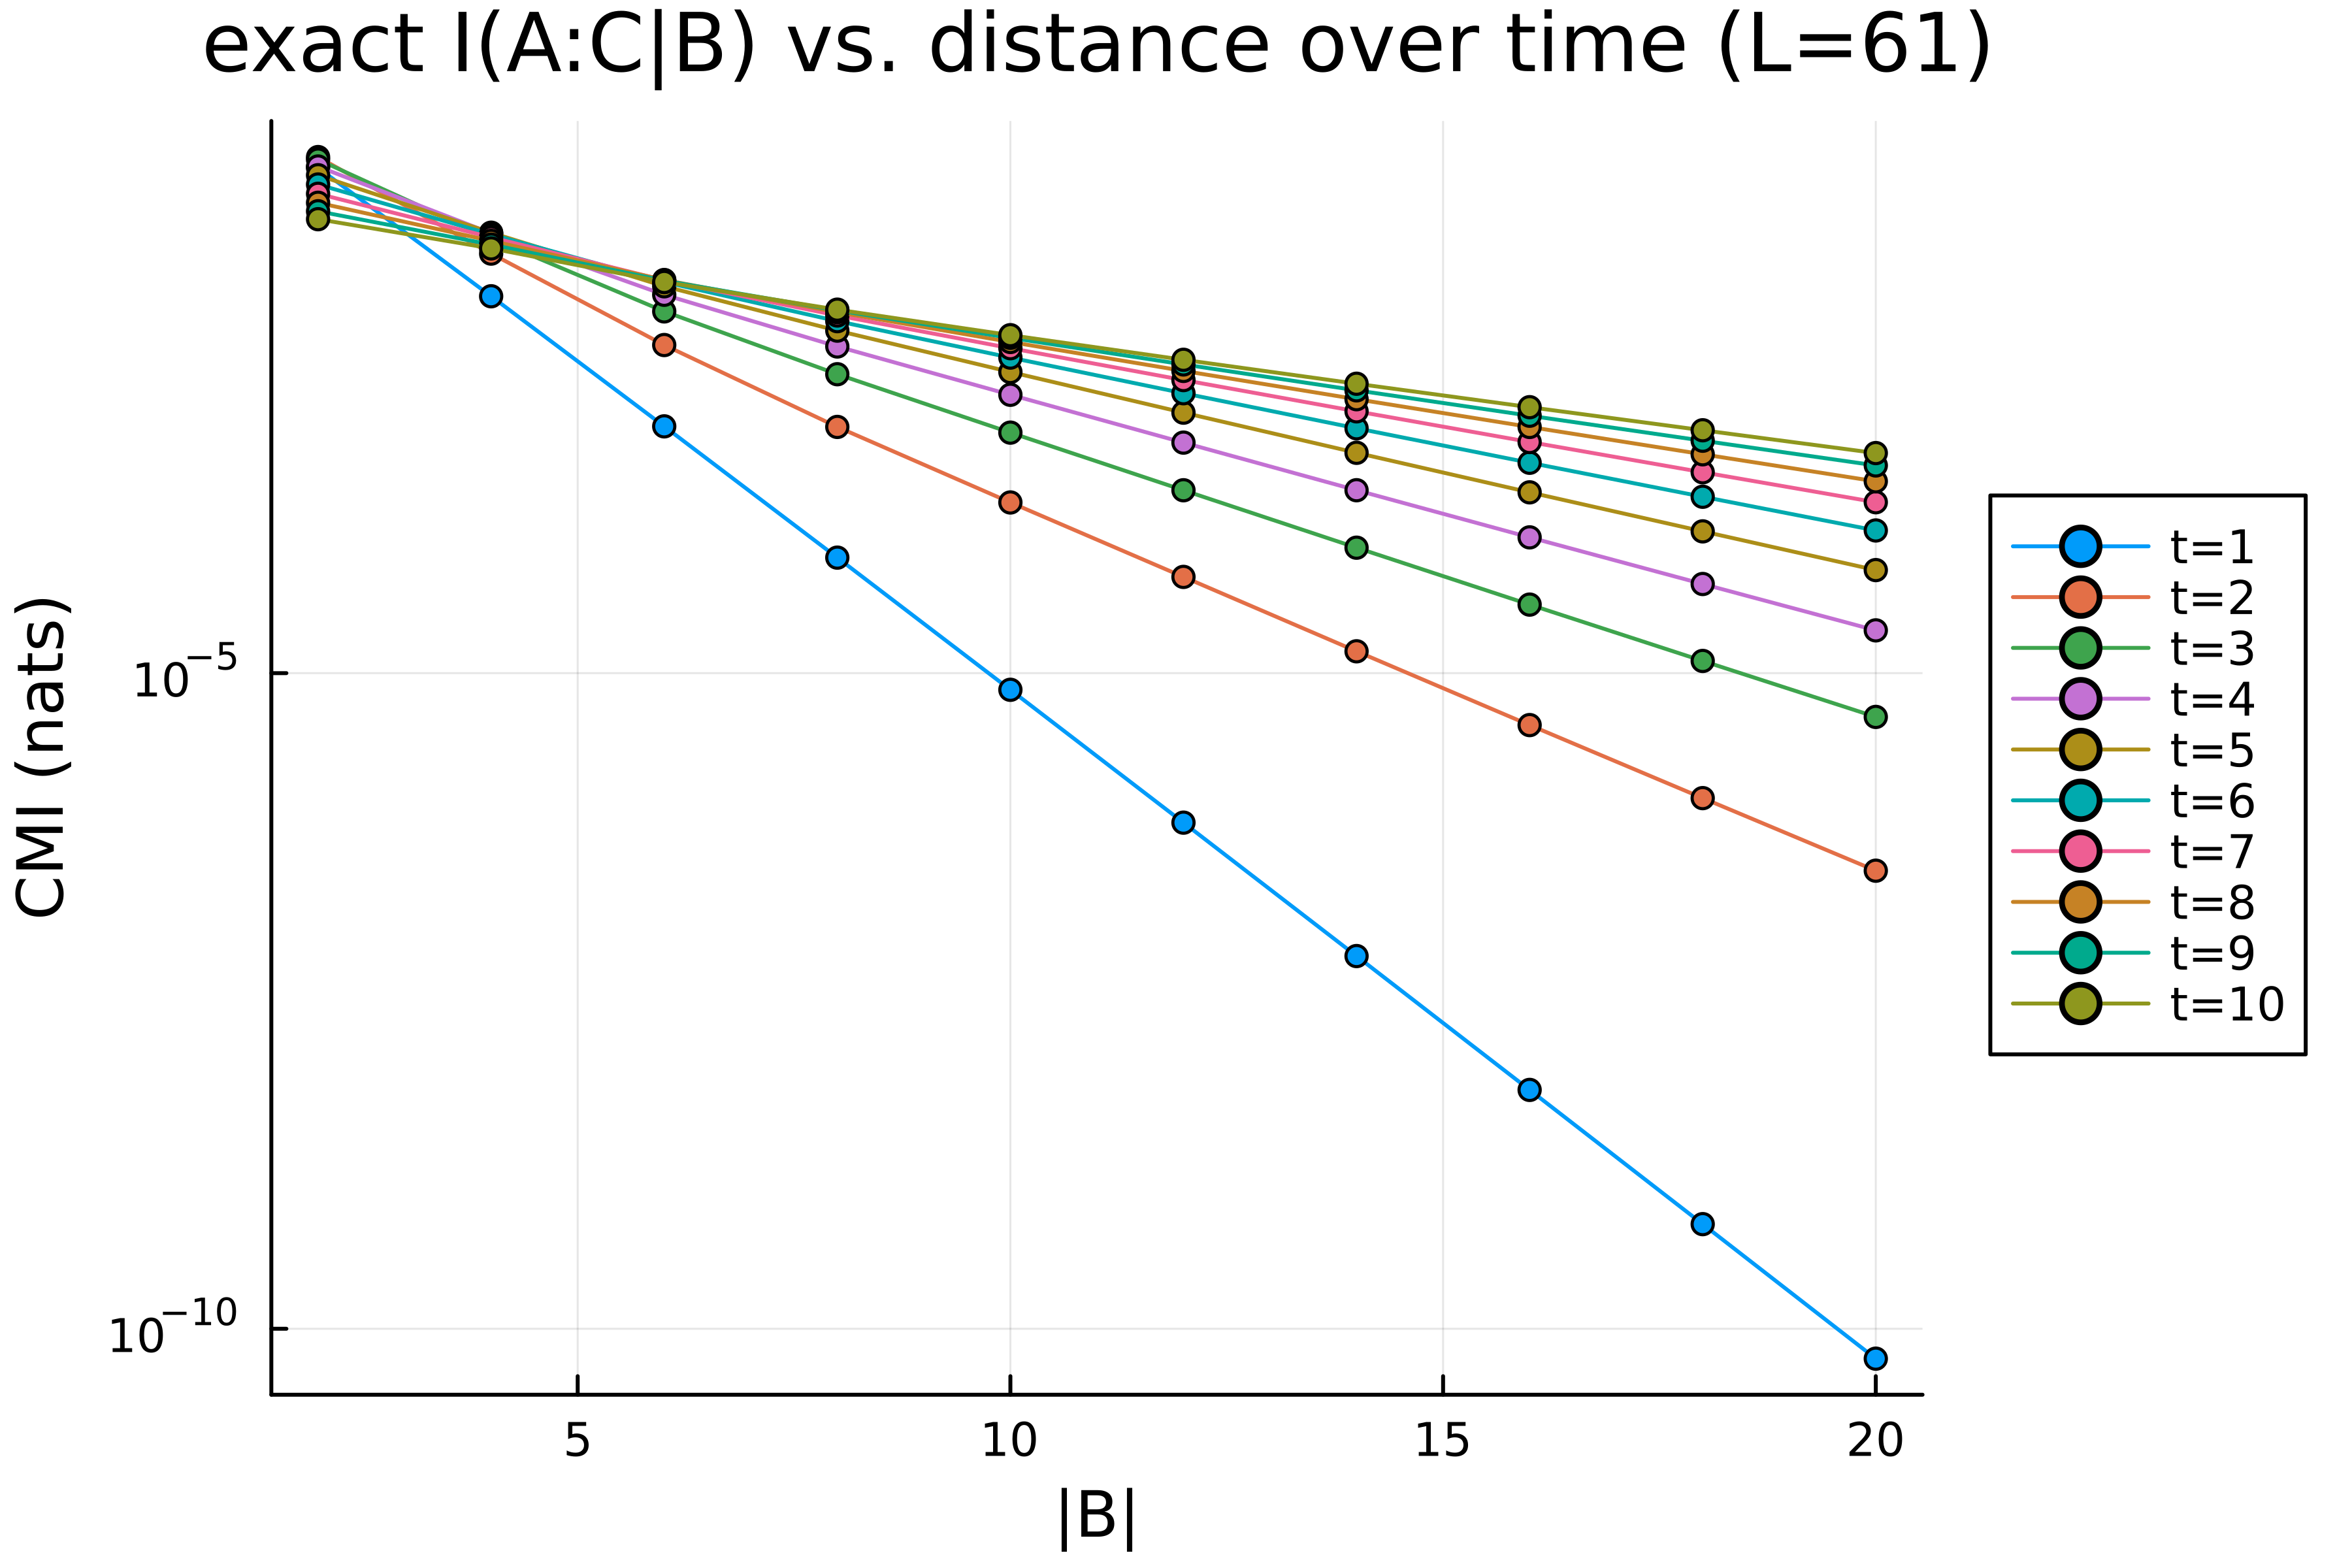

In [375]:
plt = plot()
L = 61
T = 10L
rs = 1:10

for t in 1:10
    xs = rs
    ys = [full_data[(L,T,γ,λ,r)][:exact_CMI_corr][1+2t] for r in rs]

    plt = plot!(plt, 2xs, ys, label="t=$t", m=3, yscale=:log10, legend=:outerright)
end

plot!(plt, xlabel="|B|", ylabel="CMI (nats)", title="exact I(A:C|B) vs. distance over time (L=61)", dpi=600)

savefig(plt, "../figs/25_09_24/CMI_early_times.png")

plt


# for t in 0.5:0.5:10.0
#     xs = rs
#     ys = [full_data[(L,T,γ,λ,r)][:exact_CMI_corr][1+2Int(round(t*L))] for r in rs]

#     plt = plot!(plt, 2xs, ys, label="t/L=$t", m=3, yscale=:log10, legend=:outerright)
# end
# plt

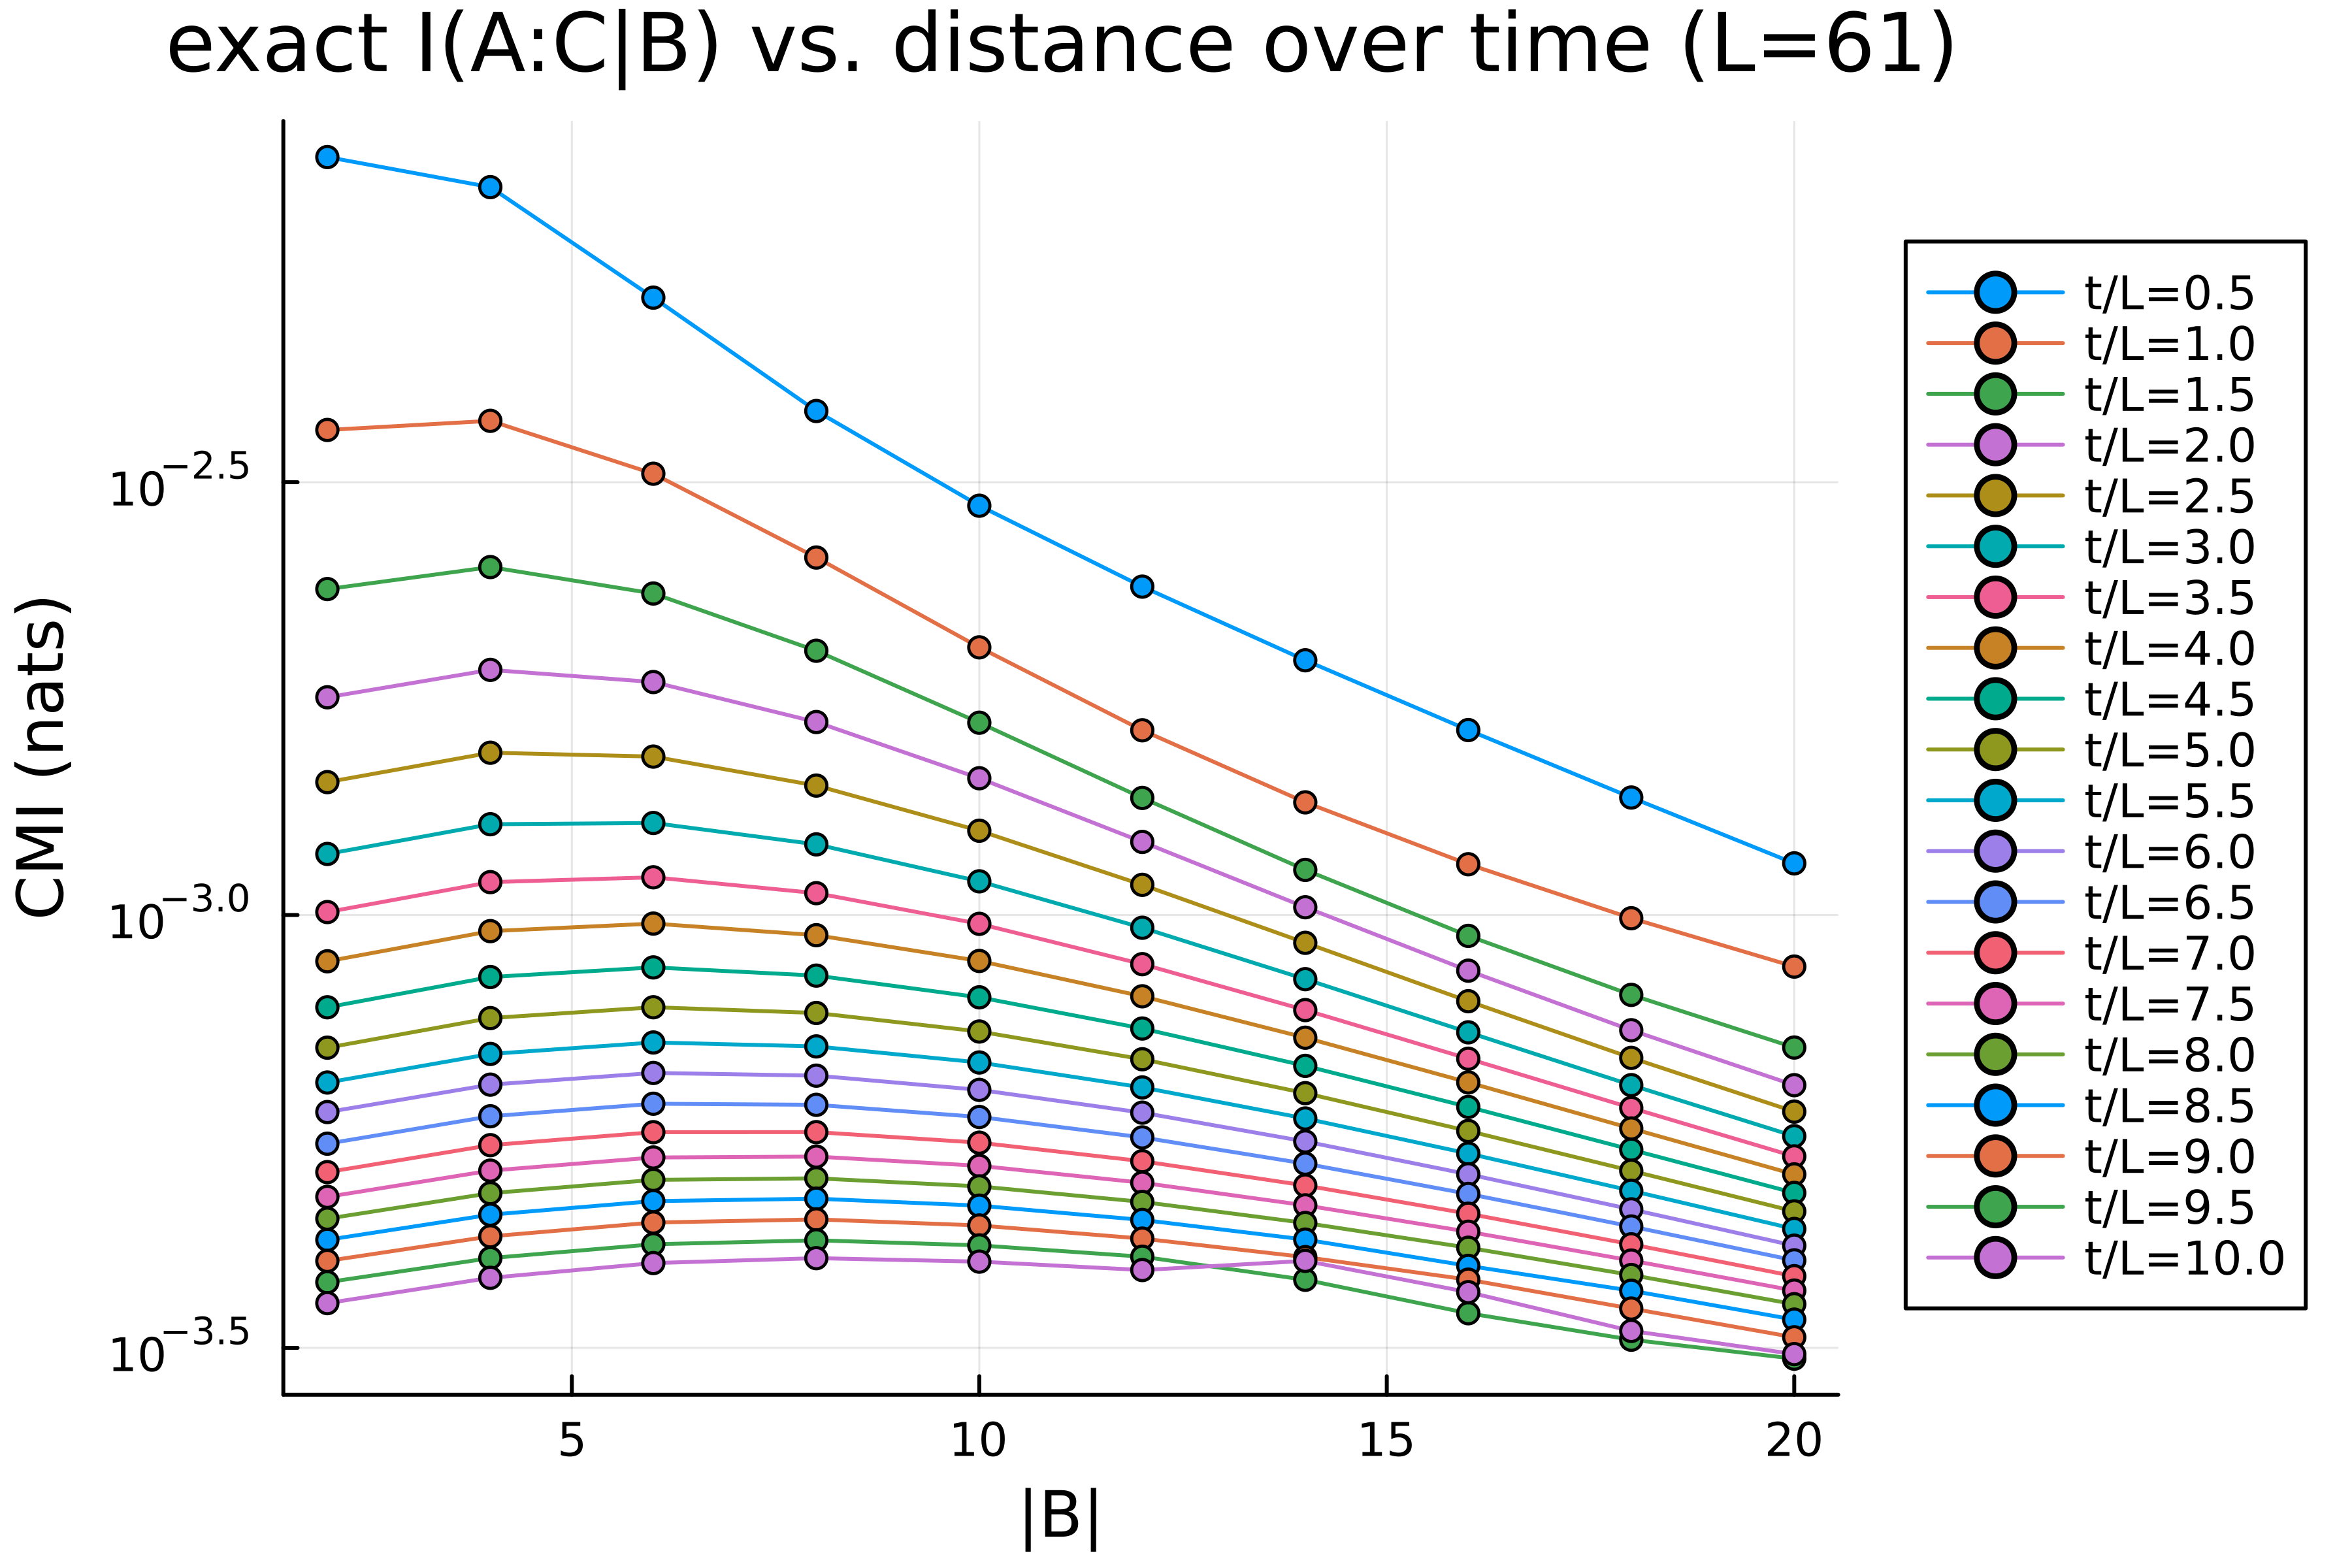

In [376]:
plt = plot()
L = 61
T = 10L
rs = 1:10

for t in 0.5:0.5:10.0
    xs = rs
    ys = [full_data[(L,T,γ,λ,r)][:exact_CMI_corr][1+2Int(round(t*L))] for r in rs]

    plt = plot!(plt, 2xs, ys, label="t/L=$t", m=3, yscale=:log10, legend=:outerright)
end

plot!(plt, xlabel="|B|", ylabel="CMI (nats)", title="exact I(A:C|B) vs. distance over time (L=61)", dpi=600)

savefig(plt, "../figs/25_09_24/CMI_late_times.png")

plt



# plt

In [271]:
L = 41
T = 10L
t = 1.5
[full_data[(L,T,γ,λ,r)][:exact_CMI_corr][Int(round(t*L))] for r in 1:2:9]

5-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0

In [105]:
vector_CMI(to_vector(ψ.mps), 14)

SAB 8.768305288262457 + 0.0im SBC 8.768307668234055 + 0.0im SB 8.402372722190858 + 0.0im SABC 8.768312456118721 + 0.0im


0.3659277781869328 + 0.0im

In [112]:
exact_CMI(ψ, 6, 10)

SAB 2.747206692646757 + 0.0im SBC 2.7470146298902263 + 0.0im SB 2.0650314677892965 + 0.0im SABC 3.425228224121552 + 0.0im


0.003961630626134749 + 0.0im

In [116]:
reduced(to_vector(ψ.mps), [8])

2-element Vector{ComplexF64}:
  0.467034780737715 + 0.0im
 0.5329652192622885 + 0.0im

In [117]:
reduced(to_vector(ψ.mps), [9])

2-element Vector{ComplexF64}:
 0.4666694484454142 + 0.0im
 0.5333305515545872 + 0.0im

In [118]:
reduced(to_vector(ψ.mps), [8,9])

4-element Vector{ComplexF64}:
   0.200357194564555 + 0.0im
 0.26667758617316095 + 0.0im
   0.266312253880861 + 0.0im
 0.26665296538142585 + 0.0im

In [125]:
a = 4
b = 10
entropy(reduced(to_vector(ψ.mps), [a])) + entropy(reduced(to_vector(ψ.mps), [b])) - entropy(reduced(to_vector(ψ.mps), [a,b]))

0.002354653353480396 + 0.0im

In [98]:
i = 1
j = 15
ρABC = reduced(ψ, i, j)
ρAB = reduced(ρABC, 1:j-i)
ρBC = reduced(ρABC, 2:j-i+1)
ρB = reduced(ρABC, 2:j-i)



8192-element Vector{ComplexF64}:
  -4.199883020382375e-11 + 0.0im
  -7.090551497269502e-11 + 0.0im
  -8.214988812381318e-11 + 0.0im
 -2.2287234857123033e-11 + 0.0im
  -9.548177938270815e-11 + 0.0im
  -2.987262787535419e-11 + 0.0im
  -3.623427392991375e-11 + 0.0im
 -2.3668432934541627e-10 + 0.0im
  -1.159011510563553e-10 + 0.0im
 -4.1539254938209255e-11 + 0.0im
                         ⋮
 -2.2356138269060273e-11 + 0.0im
   9.253509167486312e-10 + 0.0im
   3.481766596983951e-10 + 0.0im
  3.9333920006692373e-10 + 0.0im
 -2.8399214602586325e-11 + 0.0im
   4.468347358543494e-10 + 0.0im
 -3.2455694645701774e-11 + 0.0im
  -3.592730126941627e-11 + 0.0im
 -1.5906555734130952e-10 + 0.0im

In [99]:
sum(to_vector(ψ.mps))

1.0000000000000009 + 0.0im

In [100]:
sum(reduced(ψ, 1, 15))

1.0000000000000009 + 0.0im

In [93]:
ITensor(1)

ITensor ord=0
NDTensors.Dense{Float64, Vector{Float64}}